# DistilBERT with Optuna implementation and hyperparameter tuning

understanding transformer: 
- each encoder and decoder has a self attention layer & feed forward neural network
- self attention layer - encodes a token by incorporating information from other surrounding token. this provides each unique token a contextual meaning
- each self attention layeris a combination of multiple sets of query, key, value - multi head self attention 

- It does not have a decoder block 
- has encoder blocks stacked one after other
- How was bert trained?
    - masked language modelling
    - Next sentence prediction 
    - bert was simultaneousy trained on those 2 tasks

Types of tuning :
    - zero shot
    - few shot
    -fine-tuning

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import optuna

### Load data 

In [2]:
df = pd.read_csv("/Users/devishi/Uni_CW/FinalYearProject/Code/DA_FYP/sampled_glassdoor_reviews.csv")



# Rename for clarity
df = df.rename(columns={"Review_Clean": "text", "Overall Rating": "label"})
# Adjust labels: make them 0-indexed (0 to 4)
df['label'] = df['label'] - 1

# Split data (80-20 split, stratified)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)



### Tokenization

In [ ]:
model_name = "distilbert-base-uncased" # model name from Hugging Face
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # Load the tokenizer

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Evaluation func

In [4]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

### Set up model and tokenization

In [ ]:
num_labels = 5 # classes 0-4 for DistilBERT, Rating 1-5

def model_init():
    return DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

trial_results = []

# Optuna objective function
def objective(trial):
    lr    = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    bs    = trial.suggest_categorical("per_device_train_batch_size", [16,32])
    epochs= trial.suggest_int("num_train_epochs", 2, 4)

    args = TrainingArguments(
      output_dir="optuna_results",
      evaluation_strategy="epoch",
      save_strategy="no",
      per_device_train_batch_size=bs,
      per_device_eval_batch_size=32,
      learning_rate=lr,
      num_train_epochs=epochs,
      report_to="none"
    )
    trainer = Trainer(
      model_init=model_init,
      args=args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      compute_metrics=compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()  # returns {"eval_loss", "eval_accuracy", "eval_f1"}

    trial_results.append({
      "learning_rate": lr,
      "batch_size":    bs,
      "num_train_epochs": epochs,
      "accuracy":      metrics["eval_accuracy"],
      "f1":            metrics["eval_f1"]
    })
    return metrics["eval_accuracy"]

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Save every trial
pd.DataFrame(trial_results)\
  .to_csv("optuna_distilbert_trials.csv", index=False)
print("Trials logged → optuna_distilbert_trials.csv")

# Best hyperparameters
best_params = study.best_params
print("Best params:", best_params)

[I 2025-04-16 19:31:55,746] A new study created in memory with name: no-name-0cbc83aa-fea8-4fde-97ff-b2ce39f17987
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4477605819702148, 'eval_accuracy': 0.33, 'eval_f1': 0.16425563909774438, 'eval_runtime': 9.0633, 'eval_samples_per_second': 110.335, 'eval_steps_per_second': 3.531, 'epoch': 1.0}
{'loss': 1.4692, 'grad_norm': 2.5870513916015625, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.435513973236084, 'eval_accuracy': 0.336, 'eval_f1': 0.18792428915542975, 'eval_runtime': 8.8046, 'eval_samples_per_second': 113.577, 'eval_steps_per_second': 3.634, 'epoch': 2.0}
{'train_runtime': 265.4659, 'train_samples_per_second': 30.136, 'train_steps_per_second': 1.883, 'train_loss': 1.4692061767578124, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 19:36:31,014] Trial 0 finished with value: 0.336 and parameters: {'learning_rate': 2.5749539808620392e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 0 with value: 0.336.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-un

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4465551376342773, 'eval_accuracy': 0.33, 'eval_f1': 0.16425563909774438, 'eval_runtime': 8.775, 'eval_samples_per_second': 113.96, 'eval_steps_per_second': 3.647, 'epoch': 1.0}
{'loss': 1.4676, 'grad_norm': 2.6056368350982666, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4341192245483398, 'eval_accuracy': 0.338, 'eval_f1': 0.1929366155964882, 'eval_runtime': 8.7702, 'eval_samples_per_second': 114.022, 'eval_steps_per_second': 3.649, 'epoch': 2.0}
{'train_runtime': 256.4182, 'train_samples_per_second': 31.199, 'train_steps_per_second': 1.95, 'train_loss': 1.4675919189453126, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 19:40:57,816] Trial 1 finished with value: 0.338 and parameters: {'learning_rate': 2.664542808026462e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 1 with value: 0.338.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4492348432540894, 'eval_accuracy': 0.33, 'eval_f1': 0.16425563909774438, 'eval_runtime': 8.8616, 'eval_samples_per_second': 112.847, 'eval_steps_per_second': 3.611, 'epoch': 1.0}
{'loss': 1.4707, 'grad_norm': 2.6949541568756104, 'learning_rate': 7.37429603106801e-07, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4286454916000366, 'eval_accuracy': 0.345, 'eval_f1': 0.2089147175770298, 'eval_runtime': 8.7806, 'eval_samples_per_second': 113.888, 'eval_steps_per_second': 3.644, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4219679832458496, 'eval_accuracy': 0.349, 'eval_f1': 0.2264393475098276, 'eval_runtime': 8.8374, 'eval_samples_per_second': 113.155, 'eval_steps_per_second': 3.621, 'epoch': 3.0}
{'train_runtime': 388.0916, 'train_samples_per_second': 30.921, 'train_steps_per_second': 1.933, 'train_loss': 1.4538497721354167, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 19:47:35,911] Trial 2 finished with value: 0.349 and parameters: {'learning_rate': 2.212288809320403e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 2 with value: 0.349.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.421236276626587, 'eval_accuracy': 0.343, 'eval_f1': 0.2736767812911887, 'eval_runtime': 8.8276, 'eval_samples_per_second': 113.281, 'eval_steps_per_second': 3.625, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.386212944984436, 'eval_accuracy': 0.361, 'eval_f1': 0.302638923780135, 'eval_runtime': 8.7974, 'eval_samples_per_second': 113.67, 'eval_steps_per_second': 3.637, 'epoch': 2.0}
{'train_runtime': 245.8958, 'train_samples_per_second': 32.534, 'train_steps_per_second': 1.017, 'train_loss': 1.42537548828125, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 19:51:51,758] Trial 3 finished with value: 0.361 and parameters: {'learning_rate': 8.29474094783031e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2}. Best is trial 3 with value: 0.361.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unca

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2785074710845947, 'eval_accuracy': 0.427, 'eval_f1': 0.40701391118031877, 'eval_runtime': 9.1458, 'eval_samples_per_second': 109.34, 'eval_steps_per_second': 3.499, 'epoch': 1.0}
{'loss': 1.2969, 'grad_norm': 7.209370136260986, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2649502754211426, 'eval_accuracy': 0.444, 'eval_f1': 0.42483403899709526, 'eval_runtime': 9.008, 'eval_samples_per_second': 111.012, 'eval_steps_per_second': 3.552, 'epoch': 2.0}
{'train_runtime': 256.2528, 'train_samples_per_second': 31.219, 'train_steps_per_second': 1.951, 'train_loss': 1.2969306640625, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 19:56:18,285] Trial 4 finished with value: 0.444 and parameters: {'learning_rate': 2.7873214607801323e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 4 with value: 0.444.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-un

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.342343807220459, 'eval_accuracy': 0.398, 'eval_f1': 0.35907524818222614, 'eval_runtime': 8.8708, 'eval_samples_per_second': 112.73, 'eval_steps_per_second': 3.607, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2808047533035278, 'eval_accuracy': 0.427, 'eval_f1': 0.40080861902118925, 'eval_runtime': 8.9895, 'eval_samples_per_second': 111.24, 'eval_steps_per_second': 3.56, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.274294137954712, 'eval_accuracy': 0.432, 'eval_f1': 0.41406287513071494, 'eval_runtime': 8.8123, 'eval_samples_per_second': 113.478, 'eval_steps_per_second': 3.631, 'epoch': 3.0}
{'train_runtime': 370.788, 'train_samples_per_second': 32.364, 'train_steps_per_second': 1.011, 'train_loss': 1.3083909505208333, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 20:02:39,067] Trial 5 finished with value: 0.432 and parameters: {'learning_rate': 1.8853002676588857e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3}. Best is trial 4 with value: 0.444.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-un

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.320594072341919, 'eval_accuracy': 0.412, 'eval_f1': 0.3861220504547679, 'eval_runtime': 8.7596, 'eval_samples_per_second': 114.161, 'eval_steps_per_second': 3.653, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2566897869110107, 'eval_accuracy': 0.439, 'eval_f1': 0.41972943125579343, 'eval_runtime': 8.798, 'eval_samples_per_second': 113.662, 'eval_steps_per_second': 3.637, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.264265537261963, 'eval_accuracy': 0.44, 'eval_f1': 0.4277791657881706, 'eval_runtime': 8.7702, 'eval_samples_per_second': 114.023, 'eval_steps_per_second': 3.649, 'epoch': 3.0}
{'train_runtime': 370.9716, 'train_samples_per_second': 32.347, 'train_steps_per_second': 1.011, 'train_loss': 1.2457550455729167, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 20:09:00,222] Trial 6 finished with value: 0.44 and parameters: {'learning_rate': 4.0743100291661057e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3}. Best is trial 4 with value: 0.444.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4821220636367798, 'eval_accuracy': 0.331, 'eval_f1': 0.1646296018031555, 'eval_runtime': 9.058, 'eval_samples_per_second': 110.399, 'eval_steps_per_second': 3.533, 'epoch': 1.0}
{'loss': 1.5026, 'grad_norm': 2.398989677429199, 'learning_rate': 3.8829694361321234e-07, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4549187421798706, 'eval_accuracy': 0.331, 'eval_f1': 0.1646296018031555, 'eval_runtime': 9.0873, 'eval_samples_per_second': 110.044, 'eval_steps_per_second': 3.521, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.449695110321045, 'eval_accuracy': 0.33, 'eval_f1': 0.16437923250564332, 'eval_runtime': 9.1872, 'eval_samples_per_second': 108.847, 'eval_steps_per_second': 3.483, 'epoch': 3.0}
{'train_runtime': 381.6373, 'train_samples_per_second': 31.443, 'train_steps_per_second': 1.965, 'train_loss': 1.486143798828125, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 20:15:32,110] Trial 7 finished with value: 0.33 and parameters: {'learning_rate': 1.1648908308396371e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 4 with value: 0.444.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.3777265548706055, 'eval_accuracy': 0.374, 'eval_f1': 0.31453499739563334, 'eval_runtime': 9.4097, 'eval_samples_per_second': 106.273, 'eval_steps_per_second': 3.401, 'epoch': 1.0}
{'loss': 1.3812, 'grad_norm': 6.085855007171631, 'learning_rate': 3.7316746364377946e-06, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.299191951751709, 'eval_accuracy': 0.41, 'eval_f1': 0.38127619145904146, 'eval_runtime': 9.2279, 'eval_samples_per_second': 108.367, 'eval_steps_per_second': 3.468, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2794809341430664, 'eval_accuracy': 0.429, 'eval_f1': 0.4079564699956932, 'eval_runtime': 9.1866, 'eval_samples_per_second': 108.855, 'eval_steps_per_second': 3.483, 'epoch': 3.0}
{'loss': 1.2371, 'grad_norm': 6.47942590713501, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2763489484786987, 'eval_accuracy': 0.42, 'eval_f1': 0.3995478404046145, 'eval_runtime': 9.3686, 'eval_samples_per_second': 106.74, 'eval_steps_per_second': 3.416, 'epoch': 4.0}
{'train_runtime': 517.6715, 'train_samples_per_second': 30.908, 'train_steps_per_second': 1.932, 'train_loss': 1.309146728515625, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 20:24:20,001] Trial 8 finished with value: 0.42 and parameters: {'learning_rate': 7.463349272875589e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 4}. Best is trial 4 with value: 0.444.
/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unca

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4295134544372559, 'eval_accuracy': 0.336, 'eval_f1': 0.18198311419745208, 'eval_runtime': 9.2864, 'eval_samples_per_second': 107.685, 'eval_steps_per_second': 3.446, 'epoch': 1.0}
{'loss': 1.4443, 'grad_norm': 3.278661012649536, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.4098538160324097, 'eval_accuracy': 0.351, 'eval_f1': 0.2409198168230925, 'eval_runtime': 9.0416, 'eval_samples_per_second': 110.599, 'eval_steps_per_second': 3.539, 'epoch': 2.0}
{'train_runtime': 259.6946, 'train_samples_per_second': 30.805, 'train_steps_per_second': 1.925, 'train_loss': 1.444307861328125, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

[I 2025-04-16 20:28:49,841] Trial 9 finished with value: 0.351 and parameters: {'learning_rate': 4.1713084469403376e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 4 with value: 0.444.


Trials logged → optuna_distilbert_trials.csv
Best params: {'learning_rate': 2.7873214607801323e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}


### Inspect optuna tuning 

In [6]:
df_trials = pd.read_csv("optuna_distilbert_trials.csv")
df_trials.head()

,learning_rate,batch_size,num_train_epochs,accuracy,f1
0,0.000003,16,2,0.336,0.187924
1,0.000003,16,2,0.338,0.192937
2,0.000002,16,3,0.349,0.226439
3,0.000008,32,2,0.361,0.302639
4,0.000028,16,2,0.444,0.424834


In [7]:
df_trials.sort_values(by="accuracy", ascending=False).head(10)


,learning_rate,batch_size,num_train_epochs,accuracy,f1
4,0.000028,16,2,0.444,0.424834
6,0.000041,32,3,0.440,0.427779
5,0.000019,32,3,0.432,0.414063
8,0.000007,16,4,0.420,0.399548
3,0.000008,32,2,0.361,0.302639
9,0.000004,16,2,0.351,0.240920
2,0.000002,16,3,0.349,0.226439
1,0.000003,16,2,0.338,0.192937
0,0.000003,16,2,0.336,0.187924
7,0.000001,16,3,0.330,0.164379


In [8]:
df_trials.sort_values(by="f1", ascending=False).head(10)


,learning_rate,batch_size,num_train_epochs,accuracy,f1
6,0.000041,32,3,0.440,0.427779
4,0.000028,16,2,0.444,0.424834
5,0.000019,32,3,0.432,0.414063
8,0.000007,16,4,0.420,0.399548
3,0.000008,32,2,0.361,0.302639
9,0.000004,16,2,0.351,0.240920
2,0.000002,16,3,0.349,0.226439
1,0.000003,16,2,0.338,0.192937
0,0.000003,16,2,0.336,0.187924
7,0.000001,16,3,0.330,0.164379


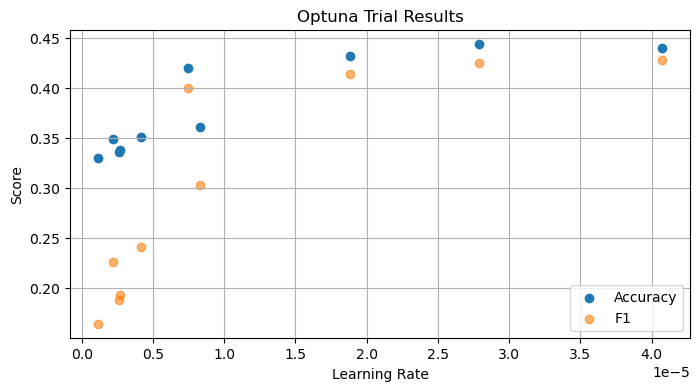

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(df_trials["learning_rate"], df_trials["accuracy"], label="Accuracy")
plt.scatter(df_trials["learning_rate"], df_trials["f1"], label="F1", alpha=0.6)
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.title("Optuna Trial Results")
plt.legend()
plt.grid(True)
plt.show()


### Train the model using the best hyperparamater

In [ ]:
# Train the best model with the best hyperparameters
best_params = {
    "learning_rate": 2.8e-5,                    
    "per_device_train_batch_size": 16,
    "num_train_epochs": 2
}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [ ]:
model_name = "distilbert-base-uncased"
def model_init():
    return DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Training arguments
training_args = TrainingArguments(
    output_dir="./distilbert_finetuned_best",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    per_device_eval_batch_size=32,
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=2
)

# Calling Trainer with the best hyperparameters
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 1.4482, 'grad_norm': 2.8935046195983887, 'learning_rate': 2.2400000000000002e-05, 'epoch': 0.4}
{'loss': 1.3198, 'grad_norm': 4.767672538757324, 'learning_rate': 1.68e-05, 'epoch': 0.8}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2893497943878174, 'eval_accuracy': 0.419, 'eval_f1': 0.4021703263313438, 'eval_runtime': 9.1305, 'eval_samples_per_second': 109.523, 'eval_steps_per_second': 3.505, 'epoch': 1.0}
{'loss': 1.3008, 'grad_norm': 6.841643333435059, 'learning_rate': 1.1200000000000001e-05, 'epoch': 1.2}
{'loss': 1.2188, 'grad_norm': 5.756470203399658, 'learning_rate': 5.600000000000001e-06, 'epoch': 1.6}
{'loss': 1.2335, 'grad_norm': 6.296639442443848, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.2717924118041992, 'eval_accuracy': 0.442, 'eval_f1': 0.42493753280486396, 'eval_runtime': 9.0169, 'eval_samples_per_second': 110.903, 'eval_steps_per_second': 3.549, 'epoch': 2.0}
{'train_runtime': 258.1586, 'train_samples_per_second': 30.989, 'train_steps_per_second': 1.937, 'train_loss': 1.304235580444336, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=1.304235580444336, metrics={'train_runtime': 258.1586, 'train_samples_per_second': 30.989, 'train_steps_per_second': 1.937, 'train_loss': 1.304235580444336, 'epoch': 2.0})

In [ ]:
# Evaluate
eval_results = trainer.evaluate()
print("Final Evaluation:", eval_results)

# Predict labels on test set
preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)


# Convert to 1–5 scale
true_labels = test_df["label"] + 1
pred_labels = pred_labels + 1


# Dataframe for prediction results
df_predictions = pd.DataFrame({
    "Review": test_df["text"].tolist(),
    "True_Label": true_labels.tolist(),
    "Predicted_Label": pred_labels.tolist()
})

df_predictions.to_csv("distilbert_predictions.csv", index=False)





Final Evaluation: {'eval_loss': 1.2717924118041992, 'eval_accuracy': 0.442, 'eval_f1': 0.42493753280486396, 'eval_runtime': 8.7057, 'eval_samples_per_second': 114.868, 'eval_steps_per_second': 3.676, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Save model and tokenizer 
trainer.model.save_pretrained("distilbert_finetuned_best")
tokenizer.save_pretrained("distilbert_finetuned_best")

('distilbert_finetuned_best/tokenizer_config.json',
 'distilbert_finetuned_best/special_tokens_map.json',
 'distilbert_finetuned_best/vocab.txt',
 'distilbert_finetuned_best/added_tokens.json',
 'distilbert_finetuned_best/tokenizer.json')

Evaluation and visualisation

In [16]:
df_bert = pd.read_csv("distilbert_predictions.csv")
df_bert.head()

,Review,True_Label,Predicted_Label
0,good pay time job short break tireless hour,3,4
1,people culture compensation hours kpi work ana...,5,4
2,opportunity grow constant feedback tiring job,4,3
3,job opportunity world internal training techno...,5,4
4,great team member facility extremely high pres...,4,5


In [ ]:

acc = accuracy_score(df_bert["True_Label"], df_bert["Predicted_Label"])
f1 = f1_score(df_bert["True_Label"], df_bert["Predicted_Label"], average="weighted")

print(f"DistilBERT Accuracy: {acc:.4f}")
print(f"DistilBERT F1 Score: {f1:.4f}")


DistilBERT Accuracy: 0.4420
DistilBERT F1 Score: 0.4249


In [18]:
from sklearn.metrics import classification_report

print(classification_report(df_bert["True_Label"], df_bert["Predicted_Label"], digits=3))


              precision    recall  f1-score   support

           1      0.466     0.380     0.419        71
           2      0.222     0.045     0.075        89
           3      0.364     0.338     0.351       231
           4      0.449     0.529     0.485       331
           5      0.494     0.568     0.528       278

    accuracy                          0.442      1000
   macro avg      0.399     0.372     0.372      1000
weighted avg      0.423     0.442     0.425      1000



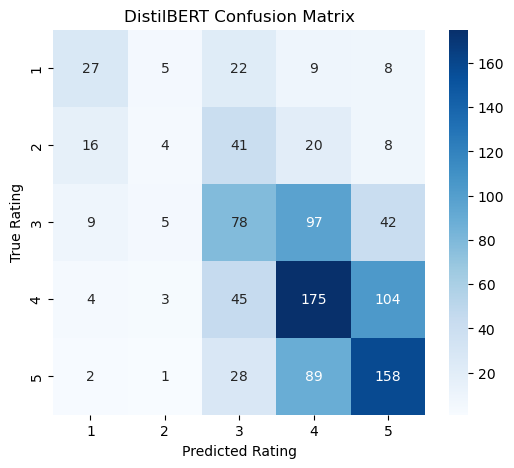

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_bert["True_Label"], df_bert["Predicted_Label"], labels=[1,2,3,4,5])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1,6), yticklabels=range(1,6))
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.title("DistilBERT Confusion Matrix")
plt.show()


In [20]:
df_errors = df_bert[df_bert["True_Label"] != df_bert["Predicted_Label"]]
df_errors[["Review", "True_Label", "Predicted_Label"]].sample(10)


,Review,True_Label,Predicted_Label
270,feed people feel satisfying minimum wage hard ...,3,4
809,great co worker easy job work night weekend,4,5
101,pro share management expect work 24/7/365,2,4
436,salary great benefit great maybe little far,4,5
123,love people work firm flexible pay hour lot up...,4,5
667,good training ground meet good brain market a...,3,4
676,brand image learning exposure fair compensatio...,3,4
145,good company future prospectus fine company,3,5
922,great compensation unmatched commission struct...,5,3
243,big firm brand resume work life balance hectic...,4,3


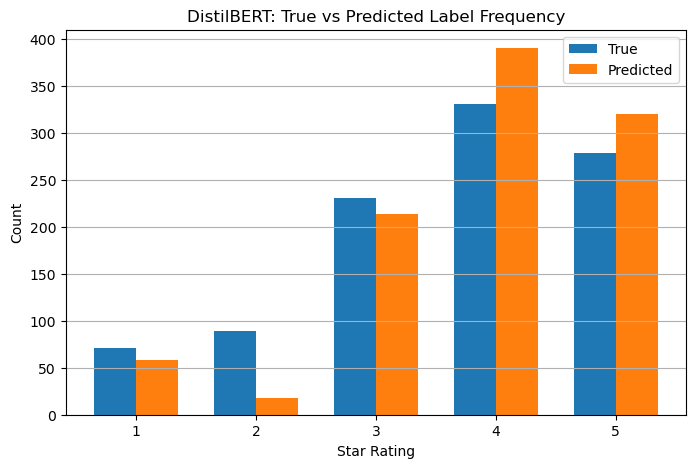

In [21]:


true_counts = df_bert["True_Label"].value_counts().sort_index()
pred_counts = df_bert["Predicted_Label"].value_counts().sort_index()
ratings = [1, 2, 3, 4, 5]

x = np.arange(len(ratings))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, true_counts, width=bar_width, label="True")
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label="Predicted")

plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("DistilBERT: True vs Predicted Label Frequency")
plt.xticks(x, ratings)
plt.legend()
plt.grid(axis="y")
plt.show()
